# Recommendations KMeans

## 💡 1. Introduction

### 1.1 Objective
The data storage solution gives us access to a lot of features of games including ratings from a wide verity of critics. The objective is to find out how good KMeans clustering is for providing game recommendations to a specified user with these given features.

### 1.2 About this document

## 📚 2. Preparations

### 2.1 Importing libraries 

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use('seaborn')

### 2.2 Importing datasets
The data storage solution provides us with three dataframes. We can easily import the ones we need with the use of storage magic. Storage magic is for lightweight persistance between notebooks. It stores variables, aliases and macros in the IPython's database.

The data storage solution can be found here:<br>
https://github.com/i442124/SuperScope/tree/main/notebooks/

More info about storage magic can be found here:<br>
https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html

In [3]:
%store -r games ratings

In [4]:
games.head()

,title,platform,publisher,genres
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nintendo,"[Action Adventure, Fantasy]"
1,Tony Hawk's Pro Skater 2,PlayStation,Activision,"[Skateboarding, Sports, Alternative]"
2,Grand Theft Auto IV,PlayStation 3,Rockstar Games,"[Modern, Action Adventure, Open-World]"
3,SoulCalibur,Dreamcast,Namco,"[Fighting, Action, 3D]"
4,Grand Theft Auto IV,Xbox 360,Rockstar Games,"[Modern, Action Adventure, Open-World]"


In [5]:
ratings.head()

,title,platform,meta_score,review_critic
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Nintendophiles
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Electronic Gaming Monthly


In [6]:
print(f'The dataset contains: {len(ratings)} ratings of {len(games)} games.')

The dataset contains: 422474 ratings of 18295 games.


## 🔎3. Examination

In [7]:
def avg_genre_matrix(ratings):
    # Split each game into multiple rows
    # for each genre they have, this makes
    # it easier to calculate the average score
    genre_ratings = pd.merge(games, ratings)
    genre_ratings = genre_ratings.explode(column='genres')

    # Calcluate average of each review_critic of each genre
    genre_ratings = genre_ratings.groupby(['review_critic', 'genres']).mean()
    genre_ratings = genre_ratings.reset_index().pivot('review_critic', 'genres', 'meta_score')
    return genre_ratings

In [8]:
genre_ratings = avg_genre_matrix(ratings)
genre_ratings.iloc[:10, :10]

genres,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade
review_critic,,,,,,,,,,
1UP,74.919811,66.234657,86.25,68.013678,69.178503,70.718919,68.814815,66.880000,80.0,67.941423
360 Gamer Magazine UK,67.000000,60.000000,NaN,68.512397,66.578947,76.666667,60.000000,64.000000,NaN,70.350877
3DAvenue,72.800000,76.120000,NaN,77.053846,77.081967,78.090909,71.600000,72.666667,NaN,80.708333
3DJuegos,79.644699,76.094118,82.50,76.800560,77.829060,79.241877,76.370504,76.090909,70.5,76.445946
4Players.de,76.763948,71.652720,77.15,72.563559,73.653772,76.970000,73.478261,73.666667,NaN,69.732441
9Lives,80.615385,82.615385,NaN,77.835443,78.432432,79.333333,79.000000,81.000000,72.0,77.086957
Absolute Games,72.666667,67.347826,70.75,63.207071,66.804348,67.641026,63.412698,NaN,NaN,62.379845
Absolute Playstation,90.333333,87.090909,NaN,86.807692,90.315789,86.750000,NaN,79.833333,NaN,88.200000
AceGamez,77.050505,72.181818,91.25,74.171225,73.804627,72.674157,70.069307,69.848485,60.0,74.802048


We can see a few NaN values, which indicates that this reviewer has not scored a game in this genre. If we ignore these values we can compare the scores of all critics with each other and start looking for correlations between the different genres to see if we have a pattern in the dataset.

<AxesSubplot:xlabel='genres', ylabel='genres'>

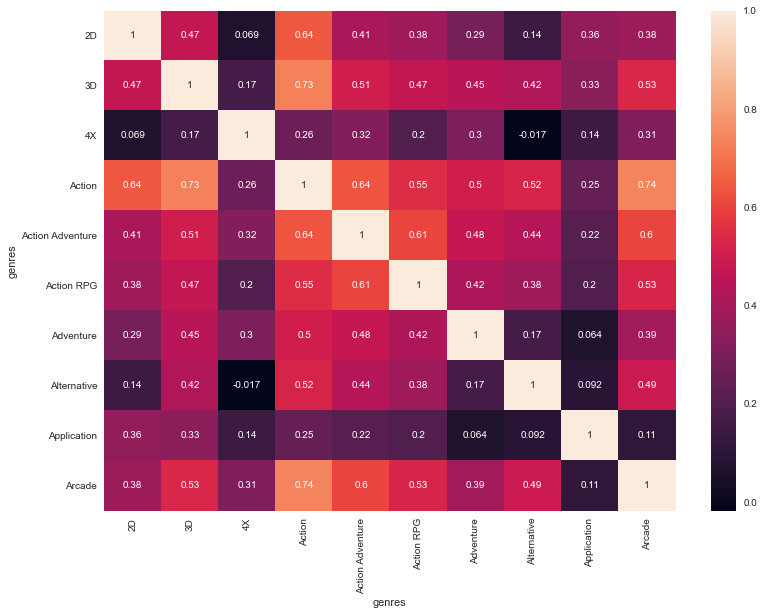

In [9]:
plt.figure(figsize=(12.8, 9.2))
sns.heatmap(genre_ratings.iloc[:, :10].corr(), annot=True)

We can see that some of these correlations are pretty good! 2D Action seems to be a very popular combination along with Action RPG and Action Adventure.

## 🧪4. Experimentation

### 4.1 Action vs Adventure
Now that we have the averages of all genres for each review critic and an idea of what good correlations we have, lets compare two of the most popular genres with each other. We can use a scatter plot where the scores of the action genre on the X axis and the adventure genre on the Y axis. Spots on the bottom left indicate that the critic doesn't like action nor adventure, while the top right indicates that the critic really loves action and adventure.

In [10]:
action_adventure = genre_ratings[['Action', 'Adventure']]
action_adventure = action_adventure[action_adventure['Action'].notna()]
action_adventure = action_adventure[action_adventure['Adventure'].notna()]

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

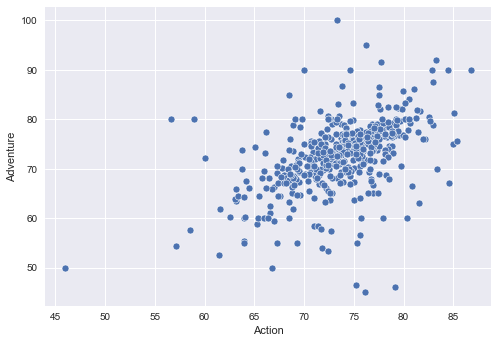

In [11]:
sns.scatterplot(data=action_adventure, x='Action', y='Adventure')

It looks like most people enjoy action adventure as the center of all points is located in the top right. Lets check out how KMeans performs when we split these review scores into two different groups. I'd expect a segmentation somewhere around the (75,75) mark.

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

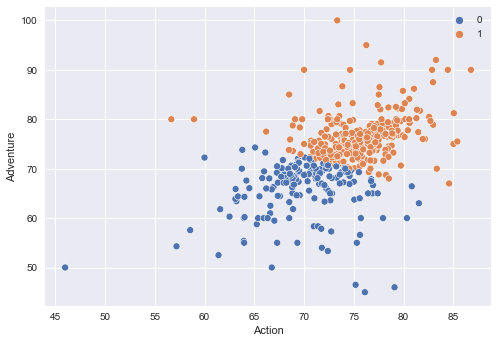

In [12]:
clusterer = KMeans(n_clusters=2)
predictions = clusterer.fit_predict(action_adventure)
sns.scatterplot(data=action_adventure, x='Action', y='Adventure', hue=predictions, palette='deep')

As we can see, the cluster that the critic belongs to depends on if they rate adventure higher than action (or visa versa). Lets check what happens when we increase the number of clusters.

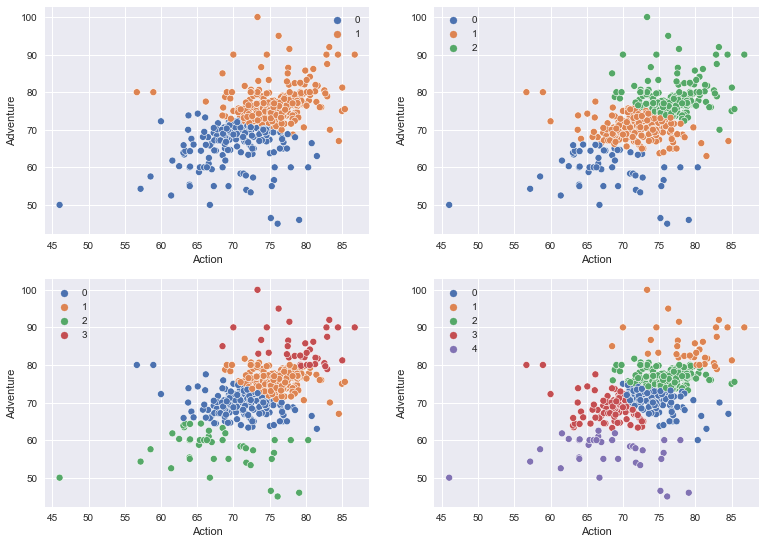

In [13]:
k_values = [2, 3, 4, 5]
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.2))

for i, k in enumerate(k_values): 
    clusterer = KMeans(n_clusters=k)
    predictions = clusterer.fit_predict(action_adventure)
    sns.scatterplot(ax=axs.ravel()[i], data=action_adventure, x='Action', y='Adventure', hue=predictions, palette='deep')

We start to see that the more clusters we use, the more similar the taste of each cluster blends in with the others. This is the exact effect we are looking for, but what would be the most optimal value?

### 4.2 Finding Optimal K

There are several techniques we can use to determine the optimal value of K. The most popular method for finding the optimal value is known as 'The Elbow Method'. Another method I found is known as the silhouette-method which I'd like to try out as well, to see how they comapre with each other.

Useful sources: <br>
https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set<br>
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb<br>

In [14]:
def elbow_method(k, data):
    clusterer = KMeans(n_clusters=k)
    pred = clusterer.fit_predict(data)
    return clusterer.inertia_

In [15]:
def silhouette_method(k, data):
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(data)
    return silhouette_score(data, pred)

Lets start off with gathering all possible k values we can go for. KMeans is limited to the amount of entires in the dataset, which for us is the total amount of critics. We can use this scope to generate a range between 2 (the minimum amount of clusters) and the amount of critics (the maximum amount of clusters). I just pick an arbitrary number `20` that I think looks good enough for a range.

In [16]:
possible_k_values = range(2, 21, 1)

First we will plot the Elbow Method. The elbow method is known for ... it's elbow shape. The value we are looking for is represented by the bend of the elbow. This point should be an indication how many (if any!?) clusters we have in the dataset. So let's figure out how many clusters we have in the action/adventure genre.

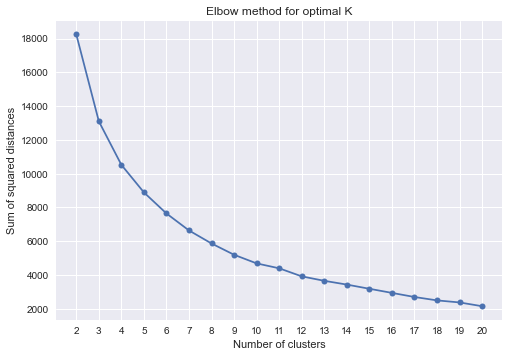

In [17]:
squared_distances = [elbow_method(k, action_adventure) for k in possible_k_values]
plt.plot(possible_k_values, squared_distances, marker='.', markersize=12)
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Elbow method for optimal K')
plt.ylabel('Sum of squared distances')
plt.xlabel('Number of clusters')
plt.show()

Looks like the sweetspot is rougly at 6
clusters. Let's compare this with the silhouette score. With the silhouette method we are most likley intrested in the highest peak on the chart.

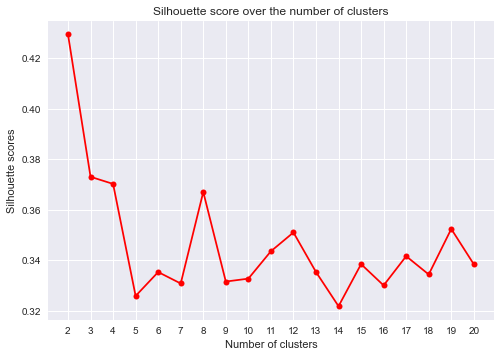

In [18]:
silhouette_scores = [silhouette_method(k, action_adventure) for k in possible_k_values]
plt.plot(possible_k_values, silhouette_scores, marker='.', markersize=12, color='red')
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Silhouette score over the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette scores')
plt.show()

Whats intresting about this plot is that it's peak is already at two, which happens to be the amount of genres that we are trying to compare. Ignoring that part, we see a few peaks here and there. Depending on what kind of clustering we need (blended or abstract) we can choose accordingly.

## ⚙️ 4. Settings

In [19]:
## Amount of clusters that the
# reviewers should be devided into
K_CLUSTERS = 8

## Score reduction strength for games
## with a low amount of reviews in cluster
PENALIZER_STRENGTH = 1

## Platforms that you want
## to get recommendations for
SUPPORTED_PLATFORMS = ['Switch']

## How to resolve NaN values for 
## critics that haven't played a genre
## possible values: 'drop', 'mean', 'zeros' and 'neutral'
IMPUTATION_RESOLVER = 'neutral'

## Minimum amount of reviews
## that the game must have
MIN_REVIEWS_COUNT = 0

## Minimum amount of reviews that
## the critic must have written
MIN_REVIEWS_WRITTEN = 325

## Minimum amount of reviews in
## for a genre in order to be clustered
MIN_REVIEWS_IN_GENRE = 75

In [20]:
MY_GAME_REVIEWS = pd.DataFrame({
    'title': [
        'Xenoblade Chronicles: Definitive Edition',
        'The Legend of Zelda: Breath of the Wild',
        'Super Smash Bros. Ultimate',
        'Super Mario Odyssey'
    ],
    'platform': 'Switch',
    'review_critic': 'Self',
    'meta_score': [90, 82, 85, 78],
})

MY_GAME_REVIEWS

,title,platform,review_critic,meta_score
0,Xenoblade Chronicles: Definitive Edition,Switch,Self,90
1,The Legend of Zelda: Breath of the Wild,Switch,Self,82
2,Super Smash Bros. Ultimate,Switch,Self,85
3,Super Mario Odyssey,Switch,Self,78


## 🧮 5. User-Genre Matrix 

Now that we have confirmed that there is a strong releation between the review_critics and gernes and have a basic of KMeans will operate, we can start looking at the bigger picture. Instead of comparing two genres with each other, we want to compare them all with each other.

### 5.1 Feature selection
Lets start off by filtering some of the ratings in the dataset that we don't want/need. A smaller dataset will improve the performance a lot. Critics that don't write enough reviews and games that don't have enough reviews should preferably be dropped because their statistics could be inaccurate. You can tweak these parameters in the settings section.

In [21]:
ratings = ratings[ratings.groupby(['review_critic'])['review_critic'].transform('size') > MIN_REVIEWS_WRITTEN]
ratings = ratings[ratings.groupby(['title', 'platform'])['review_critic'].transform('size') > MIN_REVIEWS_COUNT]

In [22]:
print(f"The trainset contains: {len(ratings)} ratings of {len(ratings.groupby(['title', 'platform']))} games.")

The trainset contains: 392168 ratings of 18310 games.


We have two approaches on how the user could be clustered in with the other review critics. The first method is to fit all the review critics into the model and predict which cluster we belong into afterwards. The advantage of this method is that we are guarenteed to get recommendations as it's forced to place the user in a cluster even if the review scores don't quite match.

The second method is to consider ourselfs as 'critics' as well, meaning we put our collection of 'reviews' with the other critics. This gives KMeans the opportunity to put our reviews into it's own seperate cluster (thus we've become an outlier). 

Depending on the behaviour (forced recommendations that might not match or the possibility of no recommendations at all) we need to change the implementation. In this notebook I will be following the second method because I want the system to clearly communicate with the users if no appropiate recommendations were found, thus I will be adding my review scores to the list of ratings.

In [23]:
ratings = ratings.append(MY_GAME_REVIEWS)

Next we create a genre matrix (like we did before) but this time with all genres that we have available. We drop all genres that don't have enough games for them to avoid an unnecessary large matrix of information that's too sparse to get any valuable information from.

In [24]:
genre_ratings = avg_genre_matrix(ratings)
genre_ratings.dropna(inplace=True, axis=1, thresh=MIN_REVIEWS_IN_GENRE)
genre_ratings = genre_ratings[avg_genre_matrix(MY_GAME_REVIEWS).columns]

Let's quickly confirm the distribution to avoid a bias to a specific genre

<AxesSubplot:>

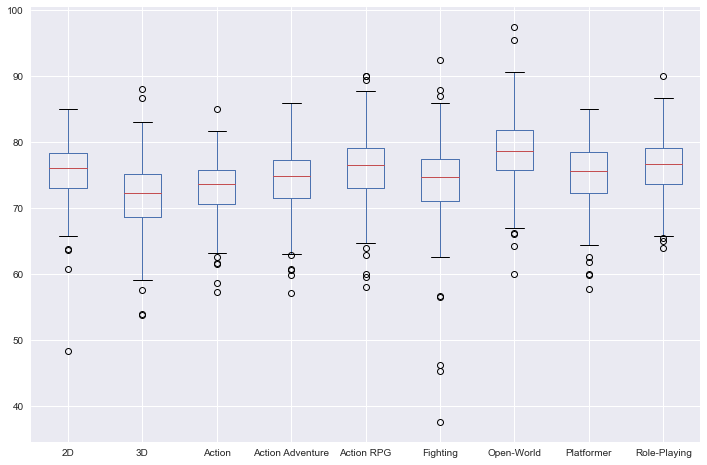

In [25]:
genre_ratings.boxplot(figsize=(12, 8))

### 5.2 Imputation
Next, we need to decide what to do with critics that don't provide reviews for a genre. KMeans operates very poorly on missing values so we need to imputate something (or drop all togheter). You can use the imputation resolver in the settings to quickly see the differences between all methods.

In [26]:
if IMPUTATION_RESOLVER == 'drop':
    genre_ratings = genre_ratings.dropna()
elif IMPUTATION_RESOLVER == 'zeros':
    genre_ratings = genre_ratings.fillna(value=0)
elif IMPUTATION_RESOLVER == 'neutral':
    genre_ratings = genre_ratings.fillna(value=50)
elif IMPUTATION_RESOLVER == 'mean':
    genre_ratings = genre_ratings.fillna(genre_ratings.mean())

In [27]:
print(f"The dataset contains: {len(genre_ratings)} review critics for {len(genre_ratings.columns)} genres.")

The dataset contains: 276 review critics for 9 genres.


### 5.3 Standardisation
When applying K-means clusterings it's best to always standardize the data before fitting. Standardisation reduces the risks of miscalculations between the distances of data. We can easily apply this by using the preprocessing library provided by sklearn.

In [28]:
SS = StandardScaler(with_mean=True, with_std=True)
scaled_ratings = SS.fit_transform(genre_ratings)

## 🧠 6. KMeans Clustering

### Cheat sheet

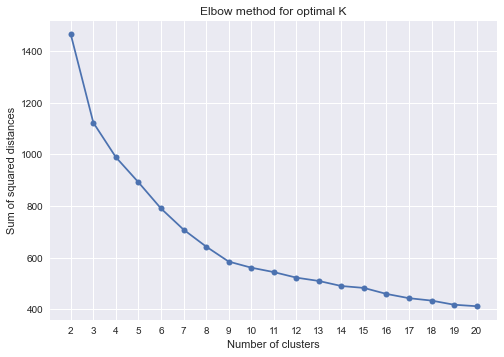

In [29]:
squared_distances = [elbow_method(k, scaled_ratings) for k in possible_k_values]
plt.plot(possible_k_values, squared_distances, marker='.', markersize=12)
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Elbow method for optimal K')
plt.ylabel('Sum of squared distances')
plt.xlabel('Number of clusters')
plt.show()

### 6.1 Training the model

In [30]:
clusterer = KMeans(n_clusters=K_CLUSTERS, random_state=42)
predictions = clusterer.fit_predict(scaled_ratings)
predictions

array([3, 7, 7, 2, 3, 2, 7, 2, 0, 0, 2, 7, 7, 1, 1, 7, 1, 7, 7, 1, 3, 2,
       2, 7, 7, 2, 4, 5, 1, 5, 2, 1, 7, 7, 2, 1, 2, 7, 4, 2, 2, 2, 7, 2,
       3, 1, 3, 7, 2, 7, 2, 3, 7, 3, 3, 2, 2, 2, 2, 2, 2, 7, 3, 3, 2, 7,
       2, 7, 2, 1, 2, 3, 2, 7, 7, 3, 2, 7, 2, 0, 2, 7, 1, 2, 7, 2, 3, 3,
       7, 7, 2, 2, 3, 3, 7, 7, 7, 7, 0, 2, 3, 3, 2, 2, 3, 7, 1, 7, 2, 7,
       2, 1, 3, 3, 1, 2, 7, 1, 2, 1, 1, 7, 2, 7, 7, 4, 2, 1, 7, 4, 2, 7,
       2, 7, 7, 1, 2, 7, 2, 2, 2, 2, 7, 2, 7, 2, 7, 1, 2, 7, 4, 7, 1, 3,
       3, 7, 7, 2, 1, 3, 7, 3, 7, 7, 7, 3, 7, 2, 2, 2, 7, 4, 2, 7, 3, 3,
       2, 3, 6, 2, 3, 2, 2, 7, 0, 2, 2, 3, 2, 1, 7, 7, 3, 2, 7, 4, 2, 7,
       1, 1, 7, 2, 2, 3, 2, 7, 2, 3, 3, 2, 2, 7, 1, 7, 3, 1, 2, 3, 1, 2,
       3, 3, 1, 2, 3, 7, 7, 7, 2, 0, 1, 2, 2, 1, 2, 2, 7, 1, 2, 2, 2, 7,
       3, 0, 7, 4, 7, 2, 7, 2, 7, 0, 7, 2, 3, 2, 2, 2, 7, 3, 7, 7, 2, 3,
       2, 2, 5, 7, 3, 7, 7, 2, 7, 2, 3, 3])

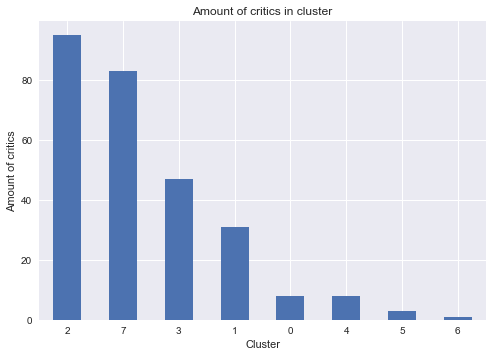

In [31]:
genre_ratings['cluster'] = predictions
genre_ratings['cluster'].value_counts().plot.bar()
plt.title('Amount of critics in cluster')
plt.ylabel('Amount of critics')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

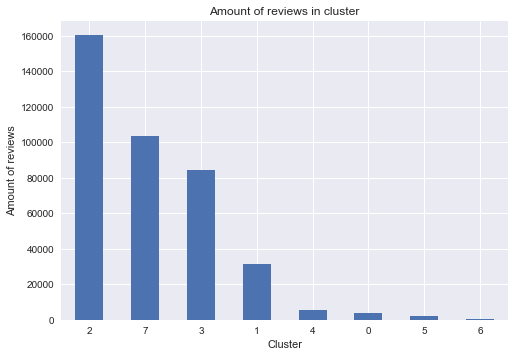

In [32]:
ratings = ratings.merge(genre_ratings.reset_index()[['review_critic','cluster']])
ratings['cluster'].value_counts().plot.bar()
plt.title('Amount of reviews in cluster')
plt.ylabel('Amount of reviews')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

In [33]:
radar = genre_ratings.groupby('cluster').mean().reset_index()
radar.columns.name = None
radar

,cluster,2D,3D,Action,Action Adventure,Action RPG,Fighting,Open-World,Platformer,Role-Playing
0,0,70.960230,67.885182,72.934289,74.406582,81.505064,63.512125,86.244048,69.951237,79.511573
1,1,81.351395,78.148179,79.024285,80.215336,81.723405,80.394098,83.374892,80.927470,81.801129
2,2,74.983158,70.614911,72.102565,73.303806,74.840755,73.475596,77.733409,74.458698,75.152118
3,3,69.856689,65.583368,66.896860,68.291314,69.580462,69.123783,73.850659,69.363955,70.408267
4,4,77.498431,76.390028,73.642663,74.842352,77.778072,73.937398,50.000000,75.890008,78.650188
5,5,59.265873,56.577857,60.056823,59.172594,59.132479,42.938424,61.481481,63.788978,65.791266
6,6,50.000000,88.000000,72.642857,50.000000,50.000000,72.250000,50.000000,50.000000,50.000000
7,7,77.754137,74.784937,75.678570,76.851556,78.498222,76.760639,80.371049,77.664658,78.511092


In [34]:
def make_spider(ax, row, color='b'):
    categories = row.index[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
    values = row.values[1:].flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    ax.set_rlabel_position(7)
    
    plt.xticks(angles[:-1], categories, color='grey', size=14)    
    plt.yticks(range(0, 100 + 20, 20), color="grey", size=11)
    plt.title(f"Cluster {int(row.cluster)}", size=18, color=color, y=1.1)

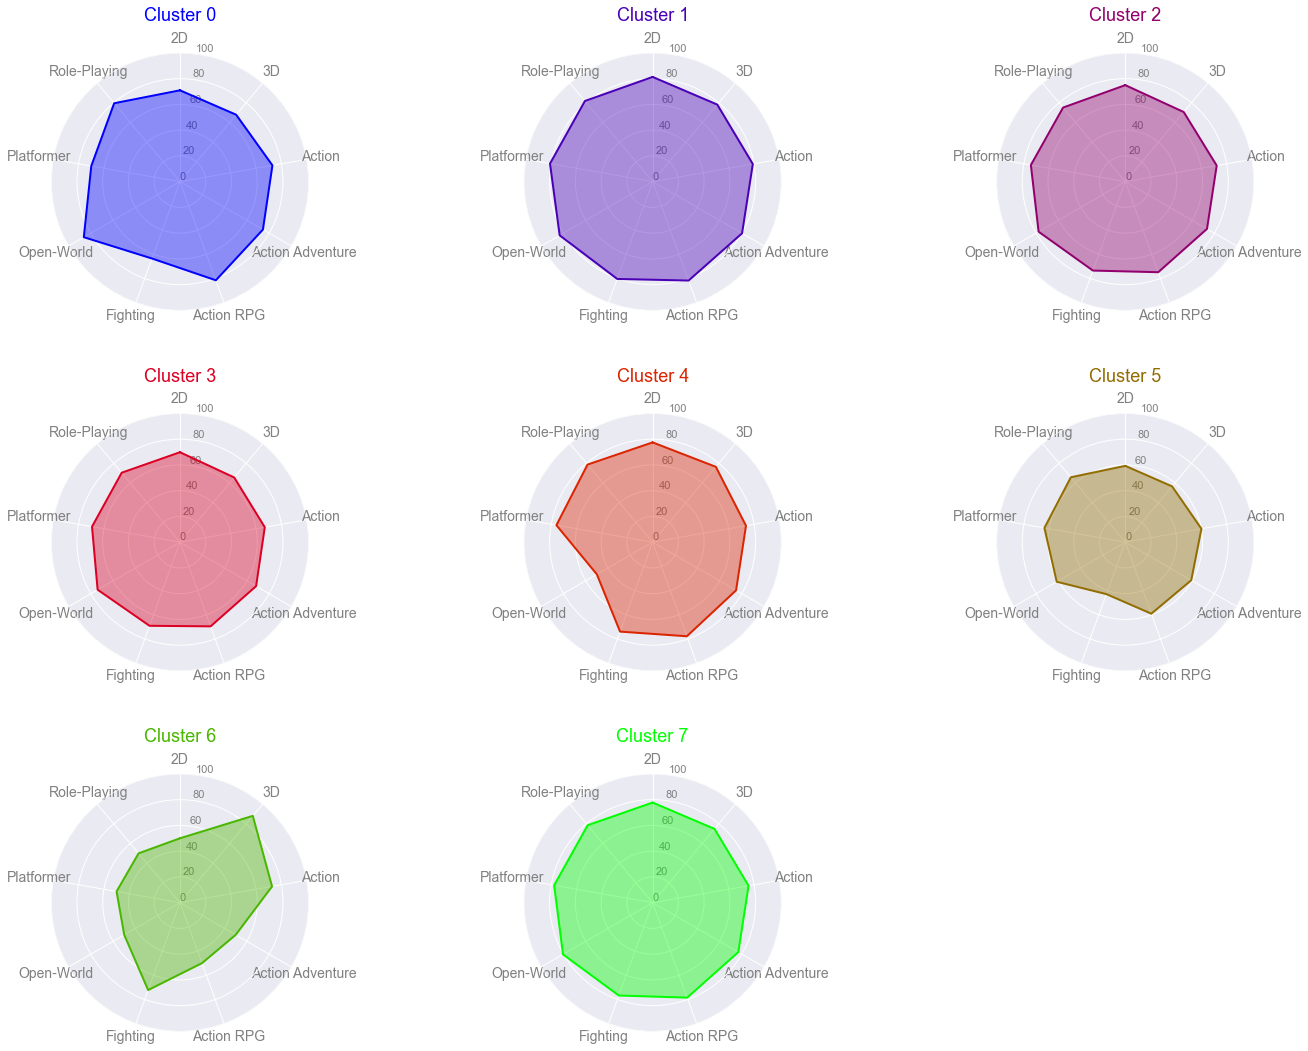

In [35]:
ncols = 3
nrows = math.ceil(len(radar.index)/ncols)
my_palette = plt.cm.get_cmap("brg", len(radar.index))

plt.figure(figsize=(24,18))
plt.subplots_adjust(hspace=0.4)

for index, row in radar.iterrows():
    ax = plt.subplot(nrows, ncols, index + 1, polar=True)
    make_spider(ax, row, color=my_palette(index))

### 6.2 Predictions

In [36]:
cluster_id = ratings[ratings['review_critic'] == 'Self']['cluster'].iloc[0]
cluster_id

1

## 📊 7. Recommendations
After determining which cluster I would belong to we can start getting all the ratings of the critics that have the same intrests as us. We no longer care about the opinions of other reviewers because they have intrests in genres we don't care about.

In [37]:
cluster = ratings[ratings['cluster'] == cluster_id]
cluster = cluster[cluster['platform'].isin(SUPPORTED_PLATFORMS)]

Great, now let's grab the mean of all the game scores and sort them by highest scored game, this should be our top recommendation!

In [38]:
cluster_ratings = cluster.groupby(['platform', 'title']).mean().reset_index()
cluster_ratings.sort_values(['meta_score'], inplace=True, ascending=False)
cluster_ratings.head(20)

,platform,title,meta_score,cluster
674,Switch,The Legend of Zelda: Breath of the Wild,97.384615,1
624,Switch,Super Mario Odyssey,96.142857,1
435,Switch,Ori and the Blind Forest: Definitive Edition,96.000000,1
278,Switch,Ikaruga,95.666667,1
162,Switch,Downwell,95.000000,1
76,Switch,Burly Men At Sea,95.000000,1
604,Switch,SteamWorld Heist: Ultimate Edition,95.000000,1
606,Switch,Steins;Gate Elite,95.000000,1
277,Switch,If Found...,95.000000,1
41,Switch,Baba Is You,95.000000,1


Not bad suggestions at all, but some of these are questionable at best. *'Sayonara Wild Hearts'*, *'Subsurface Circular'* and *'Baba is You'* are games I've certainly never heard of, so why are they this high up on the list?

In [39]:
cluster_sizes = cluster.groupby(['platform', 'title']).agg({'title':'size', 'meta_score':'mean'})
cluster_sizes = cluster_sizes.rename(columns={'title':'count'}).reset_index()
cluster_sizes.sort_values(['count'], inplace=True, ascending=False)
cluster_sizes.head(20)

,platform,title,count,meta_score
345,Switch,Mario + Rabbids: Kingdom Battle,14,89.357143
624,Switch,Super Mario Odyssey,14,96.142857
453,Switch,Paper Mario: The Origami King,14,80.642857
677,Switch,The Legend of Zelda: Link's Awakening,13,88.769231
674,Switch,The Legend of Zelda: Breath of the Wild,13,97.384615
631,Switch,Super Smash Bros. Ultimate,13,93.230769
622,Switch,Super Mario 3D World + Bowser's Fury,13,90.538462
22,Switch,Animal Crossing: New Horizons,13,91.153846
621,Switch,Super Mario 3D All-Stars,12,79.750000
407,Switch,New Super Mario Bros. U Deluxe,11,80.363636


When we start sorting on the total amount of reviews for a game, the suggestions make a lot more sense to me personally. Most of these games I've actually seen/played or at the least heard of. So, we need to find a balance between the average review score and the total amount of reviews written for that game. If we only have one review for a game in the cluster that has scored really high it's probably still not a good sugesstion for users to play. We need some kind of way to "punish" games that don't have a lot of recommendations.

We want to scale down the scores by the amount of reviews we have. The higher we get to 'infinity' the closer we want to get to the actual mean score. I think the desidered effect is best explained with a simple table that gives you a rough idea of what we want to achieve.

|  X  |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |
| --- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
|  Y  |  0.5  | 0.667 | 0.75  |  0.8  | 0.83  | 0.857 | 0.875 | 0.888 |  0.9  |

Here we can see that as X grows, the Y increases as well, but the effect weakens over time. Y will be the multiplication factor that we apply on the `meta_score`. If we have one review, the score gets devided in half, if we have two reviews it get's devided by 2/3 etc and if we have three reviews, the score get's devided by 3/4 and so forth.

The formula that belongs to the table above is the following:<br>
`Y = (X)/(X+1) * score`

The strength of the punishment is decided by the magic number `PENALIZER_STRENGTH`. If we were to increase this number the punishments get stronger and if we were to lower this number the punishments become weaker. In this case I want this effect to be pretty strong because I'd like to avoid recommending possible poor games over not recommending good games! Now let's apply this formula to our recommendations and see the results.

You can expiriment with the fomula in [WolframAlpha](https://www.wolframalpha.com/input/?i=x%2F%28x%2B1%29+from+0+to+10) or by playing with the settings.

In [40]:
weight = lambda x: (x['count'])/(x['count']+PENALIZER_STRENGTH) * x['meta_score']

In [41]:
recommendations = pd.DataFrame(cluster_sizes)
recommendations['recommendation_score'] = weight(recommendations)
recommendations.sort_values(['recommendation_score'], ascending=False).head(20)

,platform,title,count,meta_score,recommendation_score
674,Switch,The Legend of Zelda: Breath of the Wild,13,97.384615,90.428571
624,Switch,Super Mario Odyssey,14,96.142857,89.733333
631,Switch,Super Smash Bros. Ultimate,13,93.230769,86.571429
347,Switch,Mario Kart 8 Deluxe,11,93.363636,85.583333
770,Switch,Xenoblade Chronicles: Definitive Edition,10,94.000000,85.454545
22,Switch,Animal Crossing: New Horizons,13,91.153846,84.642857
622,Switch,Super Mario 3D World + Bowser's Fury,13,90.538462,84.071429
198,Switch,Fire Emblem: Three Houses,11,91.454545,83.833333
345,Switch,Mario + Rabbids: Kingdom Battle,14,89.357143,83.400000
623,Switch,Super Mario Maker 2,11,90.454545,82.916667


And there we have it, the recommendations based on my personal preference! Most of these games are the must plays of the system so it makes sense to have them at the top. Once the collection of the user grows, these will be filtered out and the more obscure titles start to become more visible to the user.

## 📝 8. Conclusion

In the beginning of the document, we've started with examining the correlations between the different genres of videogames and their scorings. After finding some interesting correlations in some of them we started to experiment with using KMeans to compare two genres with each other, namely action and adventure. We noticed that the more clusters we added, the more similar the taste of each cluster blends in with the other clusters. Due to the difficulty of measuring how many clusters we needed we utilized the elbow method (along with the silhouette score) to look for the optimal value for the number of clusters.

After confirming that there was relation between the critics and gernes and have a basic understanding on how KMeans will operate we went ahead an applied it to all genres. For preparations we decided to filter out all the data that we didn't want/need and imputed the missing values using different strategies (drop, mean, zeros and neutral). We applied some StandardScaling to avoid miscalculations between the distances of data. After that, we trained the model and have taken a look at the recommendations that were provided based on my personal favorite games.

All in all, these recommendations are not too bad! Make sure to check out the [test document](...) were I evaluate how good the model is performing for different users.

Possible ways to improve the model:
 * [A different dataset](https://www.metacritic.com/feature/game-critic-scores-vs-user-reviews) that contains information about users, not critics! In hindsight, critics try to judge games objectively resulting in similar scores of games that differ wildly in content. User behavior is more biased, which is the kind of behavior that we might need to improve the recommendations.
 * Look at the correlation between games instead of genres. This might result in more accurate predictions.